In [8]:
# https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial#:~:text=when%20using%20matplotlib%3A-,Error%20%2315%3A%20Initializing%20libiomp5.,performance%20or%20cause%20incorrect%20results.
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [9]:
with open("isochrone_grid.pkl", "rb") as fp:
    data = pickle.load(fp)
    
isochrone_m1s, isochrone_qs, isochrone_ages, isochrone_fehs, [isochrone_bs, isochrone_gs, isochrone_rs] = data
isochrone_m1s, isochrone_qs, isochrone_ages, isochrone_fehs = list(map(np.array, (isochrone_m1s, isochrone_qs, isochrone_ages, isochrone_fehs)))
isochrone_bs, isochrone_gs, isochrone_rs = list(map(np.array, [isochrone_bs, isochrone_gs, isochrone_rs]))

Text(0, 0.5, 'Age')

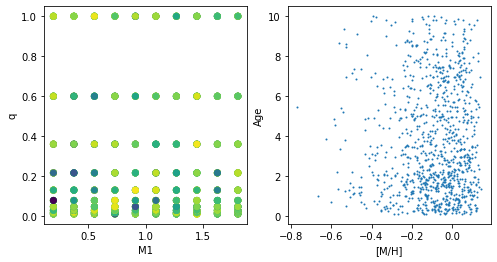

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].scatter(
    isochrone_m1s, 
    isochrone_qs,
    c=isochrone_fehs
)
axes[0].set_xlabel("M1")
axes[0].set_ylabel("q")
axes[1].scatter(
    isochrone_fehs,
    isochrone_ages,
    s=1,
)
axes[1].set_xlabel("[M/H]")
axes[1].set_ylabel("Age")

In [1]:
import torch
import numpy as np
from isochrones import get_ichrone

tracks = get_ichrone('mist', tracks=True)

def binary_color_mag_isochrones(
    m1,  # [Solar mass]
    q,   # m2/m1
    age, # [Gyr] 
    fe_h
):
    properties = tracks.generate_binary(
        m1,
        q * m1, 
        np.log10(age) + 9,  
        fe_h,
        bands=["G", "BP", "RP"]
    )
    b_mag = properties.BP_mag.values
    g_mag = properties.G_mag.values
    r_mag = properties.RP_mag.values
    return np.array([b_mag, g_mag, r_mag]).T[0]


/Users/arc/anaconda3/envs/sbi_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [2]:

# Following https://www.mackelab.org/sbi/tutorial/00_getting_started/

from sbi import utils
from sbi import analysis
from sbi.inference.base import infer

print(f"Setting prior")
method = "SNPE"
labels = ("M1", "q", "age", "[M/H]")
bounds = torch.tensor([
    [0.1,  1.8], # M1
    [0.0,    1], # q
    [0.1,   10], # age (Gyr)
    [-1,   0.5]  # metallicity
])
photometric_uncertainty_scale = 1e-4

num_simulations = 100_000

prior = utils.BoxUniform(low=bounds.T[0], high=bounds.T[1])

print(f"Emulating posterior")
def simulator(theta):
    z = torch.tensor(binary_color_mag_isochrones(*theta))
    return z + torch.randn(z.shape) * photometric_uncertainty_scale

Setting prior
Emulating posterior


In [3]:
posterior = infer(
    simulator, 
    prior, 
    method=method, 
    num_simulations=num_simulations
)

Running 100000 simulations.: 100%|█████████████████████████████████████████████████████| 100000/100000 [09:19<00:00, 178.60it/s]


 Neural network successfully converged after 170 epochs.

In [28]:
num_samples = 10_000
num_tests = len(isochrone_m1s)
num_parameters = len(labels)
percentiles = [16, 50, 84]

all_samples = np.nan * np.ones((num_tests, num_samples, num_parameters))
all_percentiles = np.nan * np.ones((num_tests, num_parameters, len(percentiles)))
all_truths = np.vstack([isochrone_m1s, isochrone_qs, isochrone_ages, isochrone_fehs]).T
all_observations = np.vstack([isochrone_bs, isochrone_gs, isochrone_rs]).T

print(all_samples.shape)
print(all_percentiles.shape)
print(all_truths.shape)
print(all_observations.shape)

(1000, 10000, 4)
(1000, 4, 3)
(1000, 4)
(1000, 3)


In [ ]:
from tqdm import tqdm

for i, observation in enumerate(tqdm(all_observations)):
    if not np.all(np.isfinite(observation)):
        continue
        
    samples = posterior.sample(
        (num_samples,), 
        x=torch.tensor(observation)
    )
    all_samples[i] = np.array(samples)
    all_percentiles[i] = np.percentile(samples, percentiles, axis=0).T

  0%|                                                                                                  | 0/1000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|                                                                | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples: 10494it [00:00, 65836.06it/s]                                                                  
  0%|                                                                                          | 1/1000 [00:00<02:44,  6.06it/s]

Drawing 10000 posterior samples:   0%|                                                                | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples: 10584it [00:00, 94055.92it/s]                                                                  
  0%|▏                                                                                         | 2/1000 [00:00<02:18,  7.22it/s]

Drawing 10000 posterior samples:   0%|                                                      

In [31]:
print(all_percentiles.shape)
print(all_truths.shape)

(1000, 4, 3)
(1000, 4)


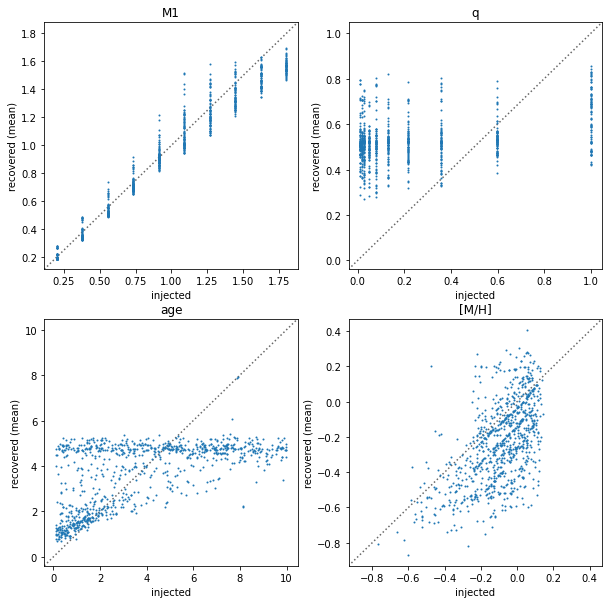

In [39]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.scatter(
        all_truths[:, i],
        all_percentiles[:, i, 1],
        s=1
    )
    limits = np.array([ax.get_xlim(), ax.get_ylim()])
    limits = (np.min(limits), np.max(limits))
    ax.plot(limits, limits, c="#666666", zorder=-1, ls=":")
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    ax.set_title(labels[i])
    ax.set_xlabel(r"injected")
    ax.set_ylabel(r"recovered (mean)")

# Does it get any better if we just use (bp - rp) and G mag?
We'll find out in `2022-06-28-injection-and-recovery-part2.ipynb`!